In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/per

In [2]:
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import os

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # chest X-rays are grayscale
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet normalization
                         std=[0.229, 0.224, 0.225])
])

In [5]:
data_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'  # e.g., 'chest_xray/train' from Kaggle
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
loader = DataLoader(dataset, batch_size=32, shuffle=False)

In [6]:
model = models.resnet18(pretrained=True)
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 82.9MB/s]


In [7]:
feature_extractor = nn.Sequential(*list(model.children())[:-1])  # remove last FC layer
feature_extractor.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [8]:
all_features = []
all_labels = []

In [9]:
with torch.no_grad():
    for images, labels in loader:
        images = images.to(device)
        features = feature_extractor(images)  # Output shape: (batch_size, 512, 1, 1)
        features = features.view(features.size(0), -1)  # Flatten to (batch_size, 512)
        all_features.append(features.cpu())
        all_labels.append(labels)

In [10]:
features_tensor = torch.cat(all_features, dim=0)
labels_tensor = torch.cat(all_labels, dim=0)

In [11]:
torch.save(features_tensor, "features.pt")

In [12]:
torch.save(labels_tensor, "labels.pt")

In [13]:
print("Feature shape:", features_tensor.shape)

Feature shape: torch.Size([5216, 512])


In [14]:
print("Label tensor shape: ", labels_tensor.shape)

Label tensor shape:  torch.Size([5216])


In [15]:
print(features_tensor)               # All feature vectors
print(features_tensor.shape)         # Shape: (num_images, 512)
print(features_tensor[0])            # Feature vector of the first image


tensor([[1.2846, 0.0000, 0.1479,  ..., 0.3009, 0.5114, 2.7711],
        [0.9733, 0.0000, 0.4676,  ..., 1.3194, 0.0000, 4.5971],
        [1.6629, 0.1303, 0.0195,  ..., 0.8673, 0.1353, 3.8136],
        ...,
        [0.9462, 2.4582, 0.6955,  ..., 1.5386, 0.2666, 3.2702],
        [0.1963, 1.2510, 1.7399,  ..., 2.2490, 0.0000, 3.1377],
        [0.2118, 0.1511, 0.3400,  ..., 2.0049, 0.0760, 3.6745]])
torch.Size([5216, 512])
tensor([1.2846e+00, 0.0000e+00, 1.4786e-01, 1.3500e+00, 1.7262e+00, 2.1529e+00,
        0.0000e+00, 6.6079e-01, 2.1117e-02, 4.1301e+00, 2.5091e-01, 2.0202e-01,
        2.6559e+00, 1.2612e+00, 4.9175e+00, 4.3781e+00, 6.5008e-01, 1.3444e+00,
        2.4143e+00, 2.1372e+00, 3.2670e-01, 0.0000e+00, 3.9309e-01, 2.4432e-02,
        3.1442e+00, 1.9407e+00, 3.2715e+00, 2.5690e-01, 5.8110e+00, 0.0000e+00,
        2.9438e+00, 1.5137e+00, 4.0926e+00, 6.2953e-01, 1.0673e+00, 4.3783e-01,
        2.7760e-02, 0.0000e+00, 2.8944e-01, 1.3989e-01, 4.4217e+00, 5.5426e-01,
        6.9485e-01

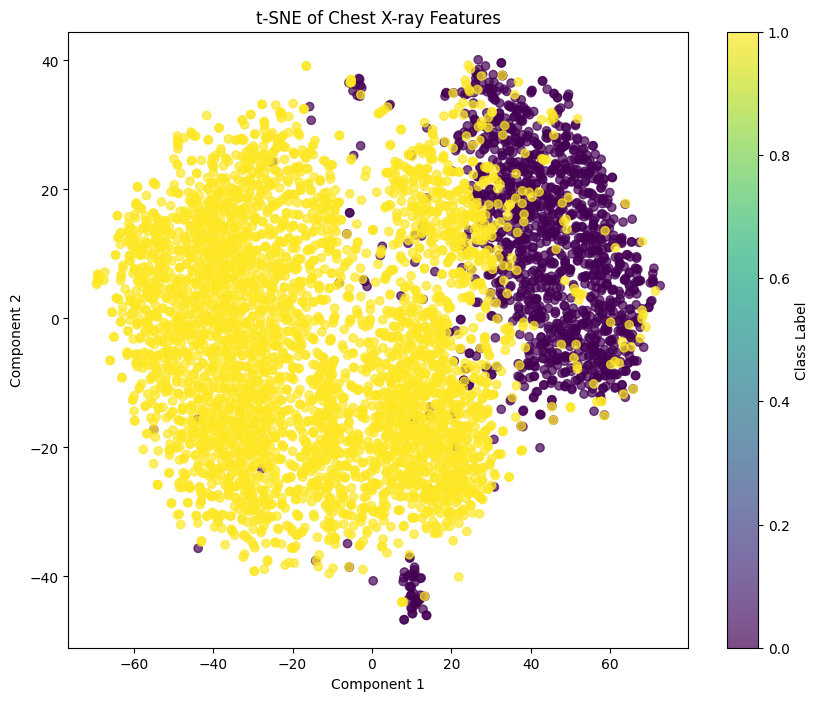

In [16]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Convert to numpy
X = features_tensor.numpy()
y = labels_tensor.numpy()

# Reduce to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_2d = tsne.fit_transform(X)

# Plot with class labels
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Class Label')
plt.title('t-SNE of Chest X-ray Features')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

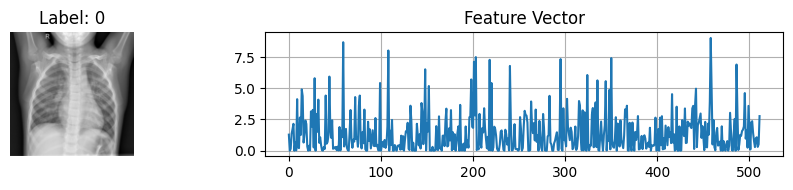

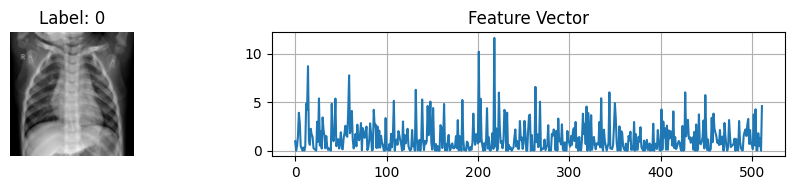

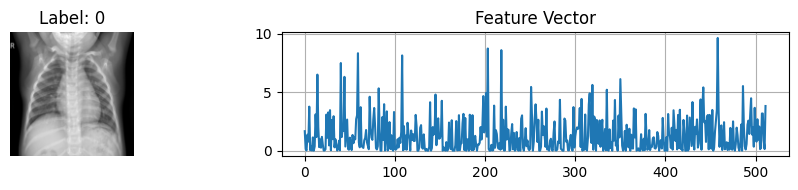

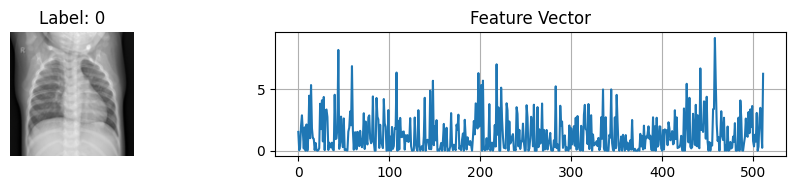

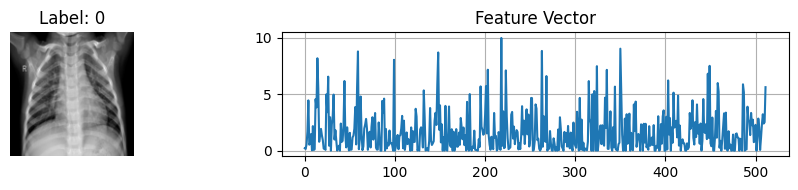

In [17]:
import matplotlib.pyplot as plt
import torchvision

inv_transform = transforms.Compose([
    transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                         std=[1/0.229, 1/0.224, 1/0.225])
])

# Pick N images
N = 5
for i in range(N):
    img_tensor, label = dataset[i]
    img = inv_transform(img_tensor).permute(1, 2, 0).numpy()  # undo normalization

    plt.figure(figsize=(10, 2))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f"Label: {label}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.plot(features_tensor[i].numpy())
    plt.title("Feature Vector")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

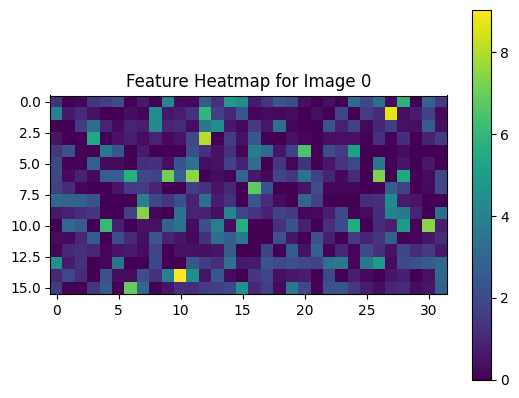

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Pick one image's feature vector
idx = 0
feature_vec = features_tensor[idx]  # shape [512]

# Normalize and reshape to 2D
feature_2d = feature_vec.reshape(16, 32)  # or (32, 16)

plt.imshow(feature_2d, cmap='viridis')  # or 'hot', 'gray'
plt.colorbar()
plt.title(f"Feature Heatmap for Image {idx}")
plt.show()


In [21]:
data_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'  # e.g., 'chest_xray/train' from Kaggle
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
loader_test = DataLoader(dataset, batch_size=32, shuffle=False)

In [22]:
model_test = models.resnet18(pretrained=True)
model_test = model_test.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:
feature_extractor = nn.Sequential(*list(model_test.children())[:-1])  # remove last FC layer
feature_extractor.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [24]:
all_features = []
all_labels = []

In [25]:
with torch.no_grad():
    for images, labels in loader_test:
        images = images.to(device)
        features = feature_extractor(images)  # Output shape: (batch_size, 512, 1, 1)
        features = features.view(features.size(0), -1)  # Flatten to (batch_size, 512)
        all_features.append(features.cpu())
        all_labels.append(labels)

In [26]:
features_tensor_test = torch.cat(all_features, dim=0)
labels_tensor_test = torch.cat(all_labels, dim=0)

In [36]:
torch.save(features_tensor_test, 'features_test.pth')
torch.save(labels_tensor_test, 'labels_test.pth')

In [28]:
print("Feature shape:", features_tensor_test.shape)
print("Label tensor shape: ", labels_tensor_test.shape)

Feature shape: torch.Size([624, 512])
Label tensor shape:  torch.Size([624])


In [29]:
X_test = features_tensor_test.numpy()
y_test = labels_tensor_test.numpy()

In [19]:
X_train = features_tensor.numpy()
y_train = labels_tensor.numpy()

In [20]:
from sklearn.svm import SVC

clf = SVC(kernel='rbf', C=1.0, gamma='scale')
clf.fit(X_train, y_train)

SVC()

In [30]:
from sklearn.metrics import classification_report, accuracy_score

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7932692307692307
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.47      0.63       234
           1       0.76      0.99      0.86       390

    accuracy                           0.79       624
   macro avg       0.86      0.73      0.74       624
weighted avg       0.83      0.79      0.77       624



In [31]:
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    roc_auc_score, roc_curve,
    precision_score,
    recall_score
)

In [32]:
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Precision: 0.8338
Recall: 0.7933
F1-score: 0.7711


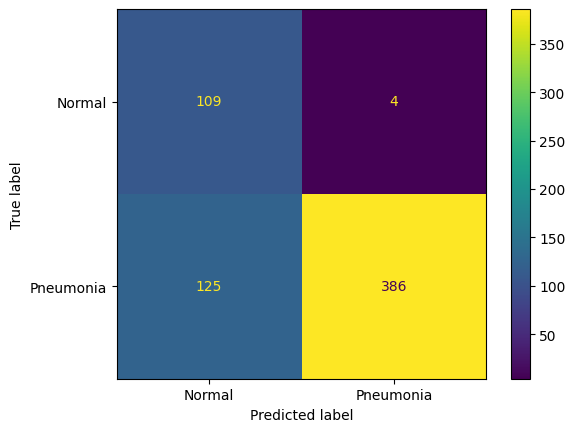

In [34]:
cm = confusion_matrix(y_pred, y_test)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Pneumonia']).plot()

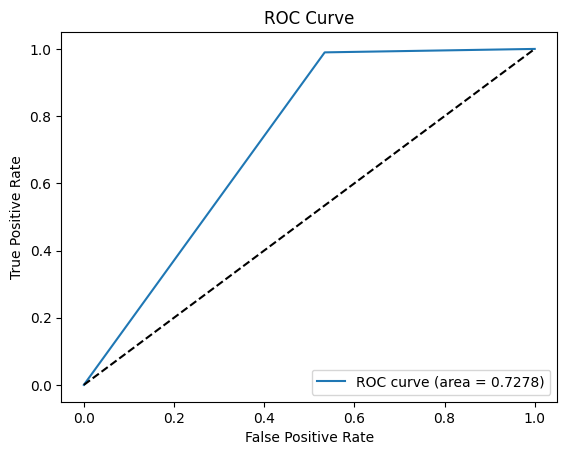

ROC-AUC Score: 0.7278


In [35]:
# Compute ROC-AUC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

print(f"ROC-AUC Score: {roc_auc:.4f}")